# Wstęp
Laboratorium 5 stanowi wprowadzenie w tematykę sieci konwolucyjnych. Sieci te wykorzystują, jak sama nazwa wskazuje, operację konwolucji (splotu) co pozwala na uwzględnienie informacji o lokalnym sąsiedztwie przestrzennym w przetwarzanych danych. W przypadku obrazów, jest to sąsiedztwo pikseli w dwuwymiarowej przestrzeni obrazu.

# Cel  ćwiczenia

Celem ćwiczenia jest zapoznianie z:

*   operacją konwolucji 2D i jej implementacją w torchu
*   warstwami konwolucyjnymi i ich parametrami
*   operacjami poolingu
*   prostymi sieciami konwolucyjnymi w klasyfikacji obrazu

# Konwolucja 2D

Najpierw wprowadzimy operację konwolucji. Konwolucja 2D przyjmuje na wejściu tensory o kształcie `(B,C,H,W)` - batch, channel, width, height. Kanały nazywamy też *mapami cech*, jako że w warstwach innych niż wejściowa są to w dalszym ciągu dwuwymiarowe "obrazki", ale odpowiadające już nie wprost kanałom RGB, ale pewnym cechom wydobywanym z mapy cech na wejściu przez uczące się filtry.

Tensor filtrów ma wymiary `(I,O,H,W)` - liczba kanałów warstwy wejściowej, liczba kanałów warstwy wyjściowej, wysokość i szerokość filtra. Możemy pomyśleć o tym przez analogię z warstwą w pełni połączoną: tam, element tensora wag `weights[i,j]` był jedną liczbą i odpowiadał połączeniu i-tego wejścia do j-tego wyjścia. W konwolucji, `weights[i,j]`  będzie odpowiadać połączeniu i-tej mapy cech do j-tej mapy cech, będzie jednak całą macierzą, ponieważ dla każdego połączenia we-wy map cech uczymy dwuwymiarowego filtra.

Dla przykładu, zaimplementujmy filtr rozmywający obraz RGB - każdy kanał z osobna. Filtr rozmywający jeden kanał definiuje `filter`, a ponieważ chcemy uzyskać połączenie tylko kanałów wejściowych do wyjściowych: R do R, G do G, B do B, a ponieważ dla każdego z tych połączeń filtr będzie taki sam, możemy po prostu wymnożyć go przez tensor `(3,3,1,1)`, utworzony z macierzy jednostkowej. W torchu taką macierz zwraca metoda `eye`.

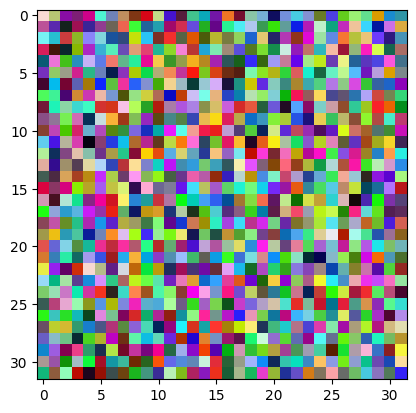

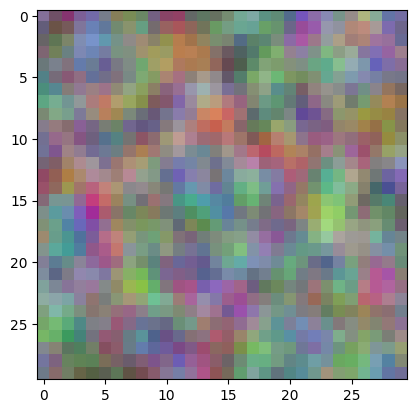

In [1]:
import torch
from matplotlib import pyplot as plt

tensor = torch.rand((1,3,32,32))

channel_connections = torch.eye(3)

filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

blur = channel_connections.view(3,3,1,1)*filter


plt.imshow(tensor[0].permute(1,2,0))
plt.show()

blurred = torch.nn.functional.conv2d(tensor,blur)

plt.imshow(blurred[0].permute(1,2,0))
plt.show()


# Zadanie 1

Zdefiniuj tensor 3x3x3x3 `rg_blur_to_b`.

Zakładając że mamy do czynienia z obrazem RGB, konwolucja na wyjściu zwracać ma obraz RGB, gdzie

* w kanale B zwracamy uśrednienie rozmytych (analogiczne jak wyżej) kanałów R, G obrazka wejściowego
* kanały R i G na wyjściu są zerami


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


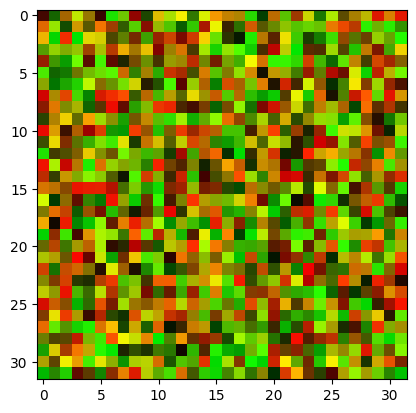

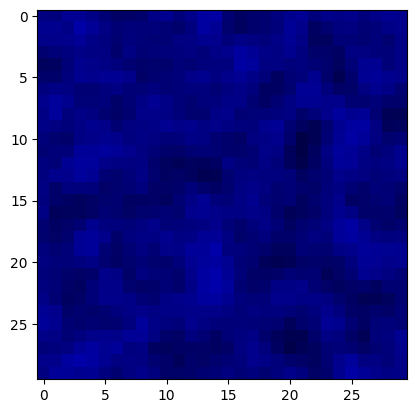

In [14]:
tensor = torch.rand((10,3,32,32))
tensor[:,2] = -7


filter = torch.tensor(
    [[0.1,0.1,0.1],
    [0.1,0.2,0.1],
    [0.1,0.1,0.1]]
)

rg_blur_to_b = torch.tensor([
    [0, 0, 0],
    [0, 0, 0],
    [0.5, 0.5, 0],
]).view(3,3,1,1)*filter


blurred = torch.nn.functional.conv2d(tensor,rg_blur_to_b)

plt.imshow(tensor[0].permute(1,2,0))
plt.show()

plt.imshow(blurred[0].permute(1,2,0))
plt.show()



# Warstwa konwolucyjna

W sieci konwolucyjnej będziemy wykorzystywać operację konwolucji tak jak opisane powyżej, w której uczone są tensor filtrów i bias dodawany do tensora na wyjściu. Warstwę z uczonymi parametrami definiuje klasa:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Pokrótce wyjaśnijmy parametry tej klasy na przykładzie filtra 2x2.

Poniższy obrazek reprezentuje lewy, górny róg mapy cech:

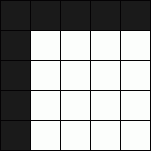

Na czerwono zaznaczymy pierwszy krok filtra przechodzącego po obrazie, na niebiesko drugi. Kolor fioletowy oznaczać będzie, że pola obejmowane przez filtry się pokrywają. Oznaczone pola przekładają się na dwa pierwsze piksele w wyjściowej mapie cech. Filtr 2x2 przy domyślnych parametrach będzie przechodził po obrazie następująco:

--------- Wejście ---------------------  Wyjście ----------

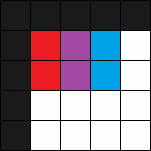
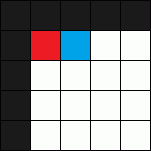


W kodzie deklarujemy w pierwszych trzech argumentach konstruktora `torch.nn.Conv2d`: liczbę kanałów wejściowych, liczbę kanałów wyjściowych, rozmiar filtra. Przy okazji, torchowa konwencja - aby podać rozmiar okna 2d możemy użyć jako argumentu zarówno krotki (x,y) jak i jednej liczby całkowitej, definiującej okno kwadratowe (x,x).

In [15]:
data_batch = torch.zeros(10,16,32,32)

#deklaracja warstwy: 16 kanałów wejściowych, 32 wyjściowych, filtr 2x2
conv_layer = torch.nn.Conv2d(16,32,2)

conv_layer(data_batch).shape

torch.Size([10, 32, 31, 31])

Jak widać, w wymiarach szerokości i wysokości, mapy cech zmniejszają się o 1.

Parametr `padding` pozwala na dodanie dodatkowych pikseli na krawędzi obrazka. Używany jest, aby zachować stałą szerokość i wysokość mapy cech po konwolucji. Dla `padding=1` pola obejmowane przez filtr będą wyglądać tak:

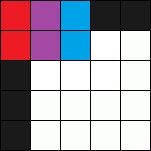

In [16]:
data_batch = torch.zeros(10,16,32,32)

conv_layer = torch.nn.Conv2d(16,16,2,padding=1)
print(conv_layer(data_batch).shape)

conv_layer = torch.nn.Conv2d(16,16,3,padding=1)
print(conv_layer(data_batch).shape)

torch.Size([10, 16, 33, 33])
torch.Size([10, 16, 32, 32])


Zauważ, że ze względu na symetryczny padding (dodawanie pikseli po obu stronach obrazu wejściowego) operacja zachowuje wysokość i szerokość tylko dla filtra o nieparzystym rozmiarze.

Parametr `stride` to krok filtra. Używany jest aby zredukować wymiary szerokości i wysokości pomiędzy kolejnymi warstwami konwolucyjnymi. `stride=2` daje nam downsampling do dwukrotnie mniejszej rozdzielczości, z wykorzystaniem uczącej się warstwy która może jednocześnie zmienić liczbę kanałów:

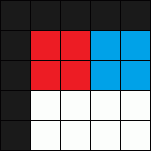


In [17]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,stride=2)

conv_layer(data_batch).shape

torch.Size([10, 16, 16, 16])

Parametr `dilation` określa rozstaw filtra. Pozwala to obejmować filtrem piksele odległe od siebie o pewną stałą wartość. Szczególnie istotnym wykorzystaniem tego parametru jest użycie sekwencji warstw, w których kolejne wartości `dilation` to kolejne potęgi 2 - efektywnie skalując rozmiar pola obejmowanego przez całą architekturę wykładniczo z głębokością. Dla `dilation=2`:

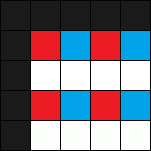

In [18]:
data_batch = torch.zeros(10,16,32,32)
conv_layer = torch.nn.Conv2d(16,16,2,dilation=2)

conv_layer(data_batch).shape

torch.Size([10, 16, 30, 30])

# Pooling

Zanim z warstw zbudujemy sieć, warto jeszcze wprowadzić operacje: poolingu i spłaszczania.

In [19]:
pool_layer =  torch.nn.MaxPool2d(2) #okno o stałym rozmiarze 2x2
adaptive_pool_layer = torch.nn.AdaptiveAvgPool2d((2, 4)) #pooling adaptacyny
flatten_layer = torch.nn.Flatten()

data_batch = torch.zeros(10,3,128,128)
pool_layer(data_batch).shape, adaptive_pool_layer(data_batch).shape, flatten_layer(data_batch).shape

(torch.Size([10, 3, 64, 64]),
 torch.Size([10, 3, 2, 4]),
 torch.Size([10, 49152]))

Dwa standardowe typy poolingu to Max i Average pooling - zwracające odpowiednio maximum lub średnią z okna pooling.

Pooling o stałym rozmiarze okna pozwala nam na downsampling w wymiarach szerokości i wysokości bez potrzeby dodawania uczącej się warstwy. Przykładowo, okno 2x2 da nam redukcję szerokości i wysokości o dwa razy.

Pooling o adaptacyjnym rozmiarze okna pozwala na sprowadzenie wyniku konwolucji do stałego, zadanego rozmiaru wysokość/szerokość, co jest szczególnie przydatne jeśli chcemy przetwarzać obrazy o różnych rozmiarach. Zwykle wykorzystuje się go tylko w jednym miejscu, przed spłaszczeniem i ostatnią warstwą w pełni połączoną. Adaptacyjna warstwa poolingu z parametrem 2 bedzie redukować rozmiar w wymiarach wysokość, szerokośc do 2 na 2 - samodzielnie wyliczając dla każdego wejścia rozmiar okna potrzebny, żeby takie wyjście uzyskać.

Spłaszczanie zaś, jak sama nazwa wskazuje spłaszcza kształt tensora z (B, C, H, W) do (B, C\*H\*W)





Aby przejść do budowania i uczenia sieci konwolucyjnych, wczytamy zbiór CIFAR10. Zdefiniujemy też funkcje wykorzystane już na poprzednich laboratoriach:

In [2]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm
from sklearn.metrics import f1_score

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader,
    val_dl: DataLoader, epochs: int,
    print_metrics: str = True
):
  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.cuda())
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics:
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              )
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )

c:\Users\Konrad\AppData\Local\Programs\Python\Python311\Lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Files already downloaded and verified
Files already downloaded and verified


Zdefiniujmy teraz prostą sieć konwolucyjną.

# Zadanie 2

Uzupełnij kod klasy `SimpleCNN` tak, aby warstwy konwolucyjne nie zmieniały szerokości i wysokości mapy cech na wyjściu oraz aby wyjście w postaci tensora miało kształt zgodny z pożądanym `(batch_size, labels)`. Użyj rozmiaru filtra 3x3.

Zauważ, że o ile warstwy konwolucyjne nie muszą znać rozmiaru obrazu, o tyle spłaszczenie obrazu i podanie do warstwy w pełni połączonej wymusza na nas zdefiniowanie tego rozmiaru z góry. Sieć zbudowana w ten sposób przetwarzać będzie tylko obrazy o stałej szerokości i wysokości. Na potrzeby zadania, sieć ma być dostosowana do zbioru CIFAR: przyjmować obrazy RGB, 32x32 na wejściu i zwracać 10-elementowy wektor na wyjściu.

In [ ]:
class SimpleCNN(torch.nn.Module):
  def __init__(self, channels: int, labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("conv_1", torch.nn.Conv2d(3, channels, 3, padding=1))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("max_pool", torch.nn.MaxPool2d(2))
    self.model.add_module("conv_2", torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear" , torch.nn.Linear(channels*16*16, labels))

  def forward(self, x):
    return self.model(x)

Zweryfikuj, że sieć zwraca wlaściwy wymiar wyjścia i zmierz czas przetwarzania konwolucji na CPU i GPU

In [213]:
cnn_model = SimpleCNN(16, 10)
out = cnn_model(torch.zeros(128,3,32,32))
assert out.shape==(128,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())


7.57 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.39 ms ± 35 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Sprawdźmy, że jesteśmy w stanie uczyć tę sieć:

In [214]:
optimizer = optim.Adam(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 5, True)

100%|██████████| 1563/1563 [00:13<00:00, 114.94it/s]


Epoch 0: train loss = 0.038 (acc: 0.569), validation loss = 0.039 (acc: 0.558)


100%|██████████| 1563/1563 [00:13<00:00, 116.43it/s]


Epoch 1: train loss = 0.033 (acc: 0.629), validation loss = 0.035 (acc: 0.610)


100%|██████████| 1563/1563 [00:13<00:00, 113.21it/s]


Epoch 2: train loss = 0.031 (acc: 0.658), validation loss = 0.034 (acc: 0.621)


100%|██████████| 1563/1563 [00:14<00:00, 107.21it/s]


Epoch 3: train loss = 0.029 (acc: 0.681), validation loss = 0.032 (acc: 0.642)


100%|██████████| 1563/1563 [00:15<00:00, 100.10it/s]


Epoch 4: train loss = 0.028 (acc: 0.690), validation loss = 0.032 (acc: 0.644)


# Zadanie 3

Zdefiniuj klasę `CNN`, sieć o strukturze

*   warstwa wejściowa in_conv o rozmiarze filtra 1x1 (transformacja liczby kanałów)
*   naprzemiennie - konwolucja, downsampling x2, konwolucja...
*   spłaszczenie wyniku do wektora
*   warstwa w pełni połączona

Klasa powinna być parametryzowalna tak, aby

*   umożliwić wybór rozmiaru filtra w warstwach konwolucji oprócz in_conv
*   umożliwić wybór zarówno liczby warstw, jak i liczby kanałów w poszczególnych warstwach konwolucyjnych
*   umożliwić wybór między downsamplingiem z użyciem poolingu a użyciem  warstwy konwolucyjnej




In [3]:
class CNN(torch.nn.Module):
  def __init__(self, 
                chanels: Tuple,
                kernel_size: int,
                labels: int,
                use_pulling: bool = True,
                input_channels: int = 3,
                ):
    
    super().__init__()
    assert len(chanels) > 0

    self.model = torch.nn.Sequential()
    self.model.add_module("in_conv", torch.nn.Conv2d(input_channels, chanels[0], 1))
    self.model.add_module("in_relu", torch.nn.ReLU())

    for i in range(1,len(chanels)):
      self.model.add_module(f"conv_{i}", torch.nn.Conv2d(chanels[i-1], chanels[i], kernel_size, padding=kernel_size//2))
      self.model.add_module(f"relu_{i}", torch.nn.ReLU())
      if use_pulling:
        self.model.add_module(f"max_pool_{i}", torch.nn.MaxPool2d(2))
      else:
        self.model.add_module(f"stride_{i}", torch.nn.Conv2d(chanels[i], chanels[i], kernel_size, stride=2, padding=kernel_size//2))
        self.model.add_module(f"relu_stride_{i}", torch.nn.ReLU())

    self.model.add_module("flatten", torch.nn.Flatten())
    
    flatten_layer_size =  32//2**(len(chanels)-1)
    self.model.add_module("linear" , torch.nn.Linear(chanels[-1]*flatten_layer_size*flatten_layer_size, labels))


  def forward(self,x):
    return self.model(x)

Zweryfikuj działanie implementacji:

In [4]:
dummy_data = torch.zeros(37,3,32,32)

cnn_model = CNN(chanels=(16,32,64), kernel_size=5, labels=15)
assert cnn_model(dummy_data).shape == (37,15)

cnn_model = CNN(chanels=(8,16,32,64), kernel_size=3, labels=10)
assert cnn_model(dummy_data).shape == (37,10)

%timeit cnn_model(torch.zeros(128,3,32,32))
cnn_model.cuda()
%timeit cnn_model(torch.zeros(128,3,32,32).cuda())

52.4 ms ± 13.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 4.10 times longer than the fastest. This could mean that an intermediate result is being cached.
2.6 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Zadanie 4

Wykorzystaj zdefiniowaną klasę, aby przeprowadzić porównania:

1.   Uczenie z filtrem 3x3 a 5x5
2.   Uczenie z Max Pooling a warstwą konwolucją do downsamplingu
3.   Uczenie z trzema warstwami o rozmiarach 16,32,64, a uczenie z trzema warstwami o rozmiarach 32,32,32

Porównaj w kontekście metryki F-score, wyrysuj krzywe uczenia. Możesz tu korzystać z kodu napisanego na poprzednich laboratoriach.


In [1]:
from torch.utils.tensorboard import SummaryWriter
import os

log_dir = './lab5/logs'
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir)

%load_ext tensorboard
%tensorboard --logdir $log_dir

Reusing TensorBoard on port 6006 (pid 26120), started 20:47:21 ago. (Use '!kill 26120' to kill it.)

In [19]:
def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    all_labels = []
    all_preds = []
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        y_pred = model(X_batch)
        loss += loss_fn(y_pred, y_batch).item()
        preds = torch.argmax(y_pred, dim=1)
        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    average_loss = loss / len(dataloader)   
    f1 = f1_score(all_labels, all_preds, average='weighted') 
    return average_loss, f1

def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader,
    val_dl: DataLoader, epochs: int,
    print_metrics: str = True,
    name: str = 'model'
):
    for epoch in range(epochs):
        for X_batch, y_batch in tqdm(train_dl):
            y_pred = model(X_batch.cuda())
            loss = loss_fn(y_pred, y_batch.cuda())

            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        model.eval()
        with torch.no_grad():
            train_loss, train_f1 = validate(
                model=model, loss_fn=loss_fn, dataloader=train_dl
            )
            val_loss, val_f1 = validate(
                model=model, loss_fn=loss_fn, dataloader=val_dl
            )

            writer.add_scalars(
                main_tag='loss',
                tag_scalar_dict={
                    f'train_{name}': train_loss,
                    f'dev_{name}': val_loss
                },
                global_step=epoch+1
            )

            writer.add_scalars(
                main_tag=f'f1',
                tag_scalar_dict={
                    f'train_{name}': train_f1,
                    f'dev_{name}': val_f1
                },
                global_step=epoch+1
            )
            if print_metrics:
                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (f1: {train_f1:.3f}), "
                    f"validation loss = {val_loss:.3f} (f1: {val_f1:.3f})"
                )

In [20]:
cnn_model = CNN(chanels=(16,32,64), kernel_size=5, labels=10).cuda()

optimizer = optim.AdamW(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 20, True, '5x5_kernel')

cnn_model = CNN(chanels=(16,32,64), kernel_size=3, labels=10).cuda()

optimizer = optim.AdamW(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 20, True, '3x3_kernel')

  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [00:15<00:00, 101.56it/s]


Epoch 0: train loss = 1.335 (f1: 0.509), validation loss = 1.355 (f1: 0.498)


100%|██████████| 1563/1563 [00:14<00:00, 105.64it/s]


Epoch 1: train loss = 1.083 (f1: 0.620), validation loss = 1.138 (f1: 0.598)


100%|██████████| 1563/1563 [00:15<00:00, 103.46it/s]


Epoch 2: train loss = 0.949 (f1: 0.660), validation loss = 1.041 (f1: 0.622)


100%|██████████| 1563/1563 [00:15<00:00, 102.86it/s]


Epoch 3: train loss = 0.863 (f1: 0.699), validation loss = 0.985 (f1: 0.654)


100%|██████████| 1563/1563 [00:15<00:00, 100.85it/s]


Epoch 4: train loss = 0.816 (f1: 0.716), validation loss = 0.969 (f1: 0.663)


100%|██████████| 1563/1563 [00:15<00:00, 102.87it/s]


Epoch 5: train loss = 0.730 (f1: 0.747), validation loss = 0.929 (f1: 0.685)


100%|██████████| 1563/1563 [00:15<00:00, 102.74it/s]


Epoch 6: train loss = 0.702 (f1: 0.753), validation loss = 0.940 (f1: 0.672)


100%|██████████| 1563/1563 [00:15<00:00, 103.04it/s]


Epoch 7: train loss = 0.635 (f1: 0.781), validation loss = 0.904 (f1: 0.690)


100%|██████████| 1563/1563 [00:15<00:00, 103.41it/s]


Epoch 8: train loss = 0.608 (f1: 0.787), validation loss = 0.923 (f1: 0.686)


100%|██████████| 1563/1563 [00:15<00:00, 101.86it/s]


Epoch 9: train loss = 0.561 (f1: 0.807), validation loss = 0.916 (f1: 0.694)


100%|██████████| 1563/1563 [00:15<00:00, 103.32it/s]


Epoch 10: train loss = 0.540 (f1: 0.815), validation loss = 0.913 (f1: 0.693)


100%|██████████| 1563/1563 [00:15<00:00, 101.92it/s]


Epoch 11: train loss = 0.501 (f1: 0.830), validation loss = 0.930 (f1: 0.695)


100%|██████████| 1563/1563 [00:15<00:00, 101.93it/s]


Epoch 12: train loss = 0.508 (f1: 0.820), validation loss = 0.975 (f1: 0.684)


100%|██████████| 1563/1563 [00:15<00:00, 102.17it/s]


Epoch 13: train loss = 0.473 (f1: 0.838), validation loss = 0.966 (f1: 0.691)


100%|██████████| 1563/1563 [00:15<00:00, 102.21it/s]


Epoch 14: train loss = 0.458 (f1: 0.841), validation loss = 0.993 (f1: 0.692)


100%|██████████| 1563/1563 [00:15<00:00, 101.70it/s]


Epoch 15: train loss = 0.426 (f1: 0.854), validation loss = 0.998 (f1: 0.688)


100%|██████████| 1563/1563 [00:15<00:00, 102.73it/s]


Epoch 16: train loss = 0.427 (f1: 0.852), validation loss = 1.046 (f1: 0.683)


100%|██████████| 1563/1563 [00:16<00:00, 95.96it/s] 


Epoch 17: train loss = 0.395 (f1: 0.861), validation loss = 1.043 (f1: 0.686)


100%|██████████| 1563/1563 [00:15<00:00, 101.29it/s]


Epoch 18: train loss = 0.363 (f1: 0.874), validation loss = 1.060 (f1: 0.689)


100%|██████████| 1563/1563 [00:15<00:00, 102.38it/s]


Epoch 19: train loss = 0.349 (f1: 0.884), validation loss = 1.058 (f1: 0.690)


100%|██████████| 1563/1563 [00:14<00:00, 106.90it/s]


Epoch 0: train loss = 1.202 (f1: 0.565), validation loss = 1.230 (f1: 0.550)


100%|██████████| 1563/1563 [00:14<00:00, 109.38it/s]


Epoch 1: train loss = 1.034 (f1: 0.645), validation loss = 1.091 (f1: 0.620)


100%|██████████| 1563/1563 [00:14<00:00, 105.86it/s]


Epoch 2: train loss = 0.908 (f1: 0.680), validation loss = 1.005 (f1: 0.646)


100%|██████████| 1563/1563 [00:14<00:00, 109.21it/s]


Epoch 3: train loss = 0.848 (f1: 0.704), validation loss = 0.969 (f1: 0.661)


100%|██████████| 1563/1563 [00:14<00:00, 110.40it/s]


Epoch 4: train loss = 0.743 (f1: 0.747), validation loss = 0.909 (f1: 0.688)


100%|██████████| 1563/1563 [00:14<00:00, 110.07it/s]


Epoch 5: train loss = 0.724 (f1: 0.752), validation loss = 0.932 (f1: 0.680)


100%|██████████| 1563/1563 [00:15<00:00, 103.43it/s]


Epoch 6: train loss = 0.689 (f1: 0.764), validation loss = 0.915 (f1: 0.683)


100%|██████████| 1563/1563 [00:14<00:00, 109.54it/s]


Epoch 7: train loss = 0.649 (f1: 0.777), validation loss = 0.911 (f1: 0.686)


100%|██████████| 1563/1563 [00:14<00:00, 110.22it/s]


Epoch 8: train loss = 0.596 (f1: 0.797), validation loss = 0.894 (f1: 0.698)


100%|██████████| 1563/1563 [00:14<00:00, 110.61it/s]


Epoch 9: train loss = 0.576 (f1: 0.799), validation loss = 0.906 (f1: 0.699)


100%|██████████| 1563/1563 [00:14<00:00, 111.28it/s]


Epoch 10: train loss = 0.536 (f1: 0.817), validation loss = 0.903 (f1: 0.699)


100%|██████████| 1563/1563 [00:14<00:00, 110.61it/s]


Epoch 11: train loss = 0.554 (f1: 0.807), validation loss = 0.942 (f1: 0.691)


100%|██████████| 1563/1563 [00:14<00:00, 106.83it/s]


Epoch 12: train loss = 0.514 (f1: 0.823), validation loss = 0.938 (f1: 0.694)


100%|██████████| 1563/1563 [00:14<00:00, 108.32it/s]


Epoch 13: train loss = 0.507 (f1: 0.822), validation loss = 0.952 (f1: 0.694)


100%|██████████| 1563/1563 [00:14<00:00, 110.33it/s]


Epoch 14: train loss = 0.471 (f1: 0.836), validation loss = 0.939 (f1: 0.697)


100%|██████████| 1563/1563 [00:14<00:00, 111.38it/s]


Epoch 15: train loss = 0.478 (f1: 0.836), validation loss = 0.981 (f1: 0.691)


100%|██████████| 1563/1563 [00:14<00:00, 110.23it/s]


Epoch 16: train loss = 0.451 (f1: 0.845), validation loss = 0.979 (f1: 0.698)


100%|██████████| 1563/1563 [00:14<00:00, 110.68it/s]


Epoch 17: train loss = 0.427 (f1: 0.854), validation loss = 0.978 (f1: 0.701)


100%|██████████| 1563/1563 [00:14<00:00, 111.59it/s]


Epoch 18: train loss = 0.417 (f1: 0.858), validation loss = 0.992 (f1: 0.697)


100%|██████████| 1563/1563 [00:14<00:00, 111.07it/s]


Epoch 19: train loss = 0.423 (f1: 0.855), validation loss = 1.034 (f1: 0.694)


In [21]:
cnn_model = CNN(chanels=(16,32,64), kernel_size=5, labels=10, use_pulling=False).cuda()

optimizer = optim.AdamW(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 25, True, '5x5_kernel_stride')

100%|██████████| 1563/1563 [00:16<00:00, 95.50it/s]


Epoch 0: train loss = 1.292 (f1: 0.526), validation loss = 1.326 (f1: 0.513)


100%|██████████| 1563/1563 [00:16<00:00, 94.29it/s]


Epoch 1: train loss = 1.035 (f1: 0.631), validation loss = 1.111 (f1: 0.599)


100%|██████████| 1563/1563 [00:16<00:00, 93.60it/s]


Epoch 2: train loss = 0.899 (f1: 0.682), validation loss = 1.019 (f1: 0.629)


100%|██████████| 1563/1563 [00:16<00:00, 93.45it/s]


Epoch 3: train loss = 0.780 (f1: 0.731), validation loss = 0.959 (f1: 0.665)


100%|██████████| 1563/1563 [00:16<00:00, 92.74it/s]


Epoch 4: train loss = 0.707 (f1: 0.754), validation loss = 0.943 (f1: 0.670)


100%|██████████| 1563/1563 [00:20<00:00, 76.90it/s]


Epoch 5: train loss = 0.672 (f1: 0.768), validation loss = 0.972 (f1: 0.669)


100%|██████████| 1563/1563 [00:20<00:00, 77.44it/s]


Epoch 6: train loss = 0.579 (f1: 0.804), validation loss = 0.941 (f1: 0.682)


100%|██████████| 1563/1563 [00:17<00:00, 88.31it/s]


Epoch 7: train loss = 0.502 (f1: 0.832), validation loss = 0.960 (f1: 0.680)


100%|██████████| 1563/1563 [00:18<00:00, 86.41it/s]


Epoch 8: train loss = 0.445 (f1: 0.848), validation loss = 0.998 (f1: 0.679)


100%|██████████| 1563/1563 [00:18<00:00, 83.19it/s]


Epoch 9: train loss = 0.393 (f1: 0.869), validation loss = 1.044 (f1: 0.677)


100%|██████████| 1563/1563 [00:17<00:00, 87.95it/s]


Epoch 10: train loss = 0.371 (f1: 0.871), validation loss = 1.127 (f1: 0.671)


100%|██████████| 1563/1563 [00:16<00:00, 92.14it/s]


Epoch 11: train loss = 0.316 (f1: 0.893), validation loss = 1.201 (f1: 0.669)


100%|██████████| 1563/1563 [00:18<00:00, 85.28it/s]


Epoch 12: train loss = 0.287 (f1: 0.904), validation loss = 1.212 (f1: 0.665)


100%|██████████| 1563/1563 [00:20<00:00, 77.06it/s]


Epoch 13: train loss = 0.259 (f1: 0.909), validation loss = 1.330 (f1: 0.661)


100%|██████████| 1563/1563 [00:20<00:00, 74.59it/s]


Epoch 14: train loss = 0.222 (f1: 0.924), validation loss = 1.415 (f1: 0.658)


100%|██████████| 1563/1563 [00:21<00:00, 72.93it/s]


Epoch 15: train loss = 0.193 (f1: 0.935), validation loss = 1.429 (f1: 0.654)


100%|██████████| 1563/1563 [00:19<00:00, 80.68it/s]


Epoch 16: train loss = 0.198 (f1: 0.929), validation loss = 1.649 (f1: 0.656)


100%|██████████| 1563/1563 [00:18<00:00, 82.76it/s]


Epoch 17: train loss = 0.156 (f1: 0.946), validation loss = 1.697 (f1: 0.651)


100%|██████████| 1563/1563 [00:20<00:00, 75.56it/s]


Epoch 18: train loss = 0.157 (f1: 0.945), validation loss = 1.738 (f1: 0.654)


100%|██████████| 1563/1563 [00:22<00:00, 70.15it/s]


Epoch 19: train loss = 0.210 (f1: 0.925), validation loss = 1.876 (f1: 0.647)


100%|██████████| 1563/1563 [00:20<00:00, 75.32it/s]


Epoch 20: train loss = 0.133 (f1: 0.954), validation loss = 1.862 (f1: 0.650)


100%|██████████| 1563/1563 [00:21<00:00, 71.51it/s]


Epoch 21: train loss = 0.124 (f1: 0.957), validation loss = 1.891 (f1: 0.649)


100%|██████████| 1563/1563 [00:20<00:00, 75.85it/s]


Epoch 22: train loss = 0.133 (f1: 0.954), validation loss = 1.912 (f1: 0.649)


100%|██████████| 1563/1563 [00:18<00:00, 85.99it/s]


Epoch 23: train loss = 0.115 (f1: 0.959), validation loss = 2.110 (f1: 0.649)


100%|██████████| 1563/1563 [00:20<00:00, 75.90it/s]


Epoch 24: train loss = 0.107 (f1: 0.963), validation loss = 2.147 (f1: 0.650)


In [22]:
cnn_model = CNN(chanels=(32,32,32), kernel_size=5, labels=10).cuda()

optimizer = optim.AdamW(cnn_model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
fit(cnn_model, optimizer, loss_fn, train_dl, test_dl, 25, True, '5x5_kernel_32_channels')



100%|██████████| 1563/1563 [00:18<00:00, 84.52it/s]


Epoch 0: train loss = 1.294 (f1: 0.537), validation loss = 1.311 (f1: 0.524)


100%|██████████| 1563/1563 [00:18<00:00, 86.13it/s]


Epoch 1: train loss = 1.127 (f1: 0.601), validation loss = 1.175 (f1: 0.584)


100%|██████████| 1563/1563 [00:18<00:00, 85.43it/s] 


Epoch 2: train loss = 1.005 (f1: 0.651), validation loss = 1.079 (f1: 0.621)


100%|██████████| 1563/1563 [00:17<00:00, 88.57it/s] 


Epoch 3: train loss = 0.942 (f1: 0.668), validation loss = 1.041 (f1: 0.632)


100%|██████████| 1563/1563 [00:20<00:00, 74.99it/s]


Epoch 4: train loss = 0.867 (f1: 0.697), validation loss = 0.996 (f1: 0.654)


100%|██████████| 1563/1563 [00:19<00:00, 81.37it/s]


Epoch 5: train loss = 0.825 (f1: 0.716), validation loss = 0.970 (f1: 0.666)


100%|██████████| 1563/1563 [00:19<00:00, 79.56it/s]


Epoch 6: train loss = 0.800 (f1: 0.722), validation loss = 0.958 (f1: 0.666)


100%|██████████| 1563/1563 [00:18<00:00, 85.23it/s]


Epoch 7: train loss = 0.788 (f1: 0.719), validation loss = 0.968 (f1: 0.664)


100%|██████████| 1563/1563 [00:19<00:00, 78.88it/s]


Epoch 8: train loss = 0.743 (f1: 0.748), validation loss = 0.932 (f1: 0.680)


100%|██████████| 1563/1563 [00:19<00:00, 81.24it/s]


Epoch 9: train loss = 0.709 (f1: 0.758), validation loss = 0.943 (f1: 0.683)


100%|██████████| 1563/1563 [00:16<00:00, 96.76it/s] 


Epoch 10: train loss = 0.704 (f1: 0.755), validation loss = 0.947 (f1: 0.677)


100%|██████████| 1563/1563 [00:18<00:00, 85.61it/s]


Epoch 11: train loss = 0.689 (f1: 0.759), validation loss = 0.958 (f1: 0.675)


100%|██████████| 1563/1563 [00:18<00:00, 84.58it/s]


Epoch 12: train loss = 0.671 (f1: 0.768), validation loss = 0.929 (f1: 0.685)


100%|██████████| 1563/1563 [00:18<00:00, 84.13it/s]


Epoch 13: train loss = 0.646 (f1: 0.777), validation loss = 0.926 (f1: 0.685)


100%|██████████| 1563/1563 [00:20<00:00, 77.15it/s]


Epoch 14: train loss = 0.630 (f1: 0.783), validation loss = 0.939 (f1: 0.693)


100%|██████████| 1563/1563 [00:19<00:00, 80.90it/s]


Epoch 15: train loss = 0.651 (f1: 0.774), validation loss = 0.977 (f1: 0.675)


100%|██████████| 1563/1563 [00:20<00:00, 77.57it/s]


Epoch 16: train loss = 0.606 (f1: 0.793), validation loss = 0.939 (f1: 0.691)


100%|██████████| 1563/1563 [00:17<00:00, 91.05it/s]


Epoch 17: train loss = 0.623 (f1: 0.786), validation loss = 0.964 (f1: 0.684)


100%|██████████| 1563/1563 [00:16<00:00, 93.37it/s]


Epoch 18: train loss = 0.604 (f1: 0.790), validation loss = 0.970 (f1: 0.685)


100%|██████████| 1563/1563 [00:18<00:00, 85.74it/s] 


Epoch 19: train loss = 0.601 (f1: 0.793), validation loss = 0.976 (f1: 0.685)


100%|██████████| 1563/1563 [00:19<00:00, 80.70it/s]


Epoch 20: train loss = 0.573 (f1: 0.805), validation loss = 0.969 (f1: 0.690)


100%|██████████| 1563/1563 [00:19<00:00, 78.35it/s]


Epoch 21: train loss = 0.578 (f1: 0.803), validation loss = 0.971 (f1: 0.685)


100%|██████████| 1563/1563 [00:19<00:00, 81.69it/s]


Epoch 22: train loss = 0.562 (f1: 0.805), validation loss = 0.971 (f1: 0.689)


100%|██████████| 1563/1563 [00:19<00:00, 82.23it/s]


Epoch 23: train loss = 0.560 (f1: 0.807), validation loss = 0.989 (f1: 0.686)


100%|██████████| 1563/1563 [00:19<00:00, 80.38it/s]


Epoch 24: train loss = 0.532 (f1: 0.818), validation loss = 0.969 (f1: 0.693)
